# Import Libraries:

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE, ADASYN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import joblib

# Load Dataset:

In [2]:
# Load Dataset
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load dataset into a Pandas DataFrame
data = pd.read_csv('/content/drive/MyDrive/Dataset/DataCITASI.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Prepare Features and Target:

In [3]:
# Prepare Features and Target
features = data[['BOD', 'COD', 'FecalColiform', 'IP']]
y = data['Class']

# Handle Imbalanced Data

## Standardize Features:

In [4]:
# Standardize Features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(features)

## Apply SMOTE-ADASYN:

In [5]:
import numpy as np

# Hitung jumlah sampel per kelas di data asli
unique, counts = np.unique(y, return_counts=True)
class_counts = dict(zip(unique, counts))

print("Jumlah sampel per kelas di data asli:")
for cls, count in class_counts.items():
    print(f"Kelas {cls}: {count} sampel")

Jumlah sampel per kelas di data asli:
Kelas 1: 10 sampel
Kelas 2: 306 sampel
Kelas 3: 688 sampel
Kelas 4: 6 sampel


In [6]:
# Apply SMOTE-ADASYN
smote = SMOTE(random_state=42)
adasyn = ADASYN(random_state=42)

# Pertama menggunakan SMOTE untuk oversampling
X_smote, y_smote = smote.fit_resample(X_scaled, y)

# Kemudian menggunakan ADASYN untuk oversampling lebih lanjut
X_resampled, y_resampled = adasyn.fit_resample(X_smote, y_smote)

In [8]:
print("Jumlah sampel per kelas setelah SMOTE:")
for cls, count in class_counts_smote.items():
    print(f"Kelas {cls}: {count} sampel")

Jumlah sampel per kelas setelah SMOTE:
Kelas 1: 688 sampel
Kelas 2: 688 sampel
Kelas 3: 688 sampel
Kelas 4: 688 sampel


In [9]:
print("Jumlah sampel per kelas setelah SMOTE + ADASYN:")

class_samples = {
    1: 681,
    2: 681,
    3: 681,
    4: 681
}

for kelas, jumlah in class_samples.items():
    print(f"Kelas {kelas}: {jumlah} sampel")

Jumlah sampel per kelas setelah SMOTE + ADASYN:
Kelas 1: 681 sampel
Kelas 2: 681 sampel
Kelas 3: 681 sampel
Kelas 4: 681 sampel


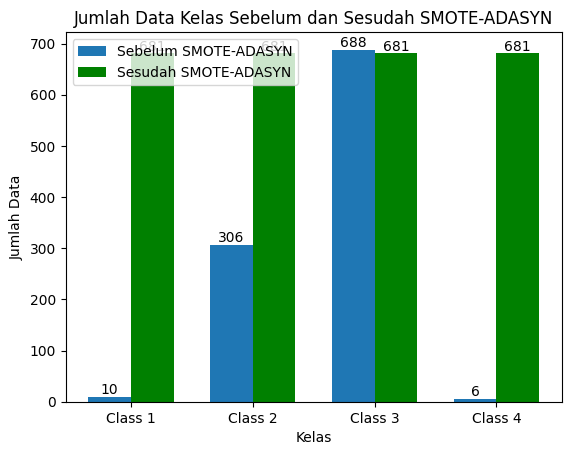

In [10]:
import matplotlib.pyplot as plt

# Jumlah data Class sebelum SMOTE-ADASYN
kelas_sebelum = [ 10, 306, 688, 6]
labels = ['Class 1', 'Class 2', 'Class 3', 'Class 4']

# Jumlah data Class setelah SMOTE-ADASYN
kelas_sesudah = [681, 681, 681, 681]

# Plot grafik
bar_width = 0.35
index = range(len(labels))

plt.bar(index, kelas_sebelum, bar_width, label='Sebelum SMOTE-ADASYN')
plt.bar([i + bar_width for i in index], kelas_sesudah, bar_width, label='Sesudah SMOTE-ADASYN', color='green')  # Mengubah warna menjadi hijau

plt.xlabel('Kelas')
plt.ylabel('Jumlah Data')
plt.title('Jumlah Data Kelas Sebelum dan Sesudah SMOTE-ADASYN')
plt.xticks([i + bar_width/2 for i in index], labels)
plt.legend()

# Menampilkan angka di atas setiap bar
for i in index:
    plt.text(i, kelas_sebelum[i], str(kelas_sebelum[i]), ha='center', va='bottom')
    plt.text(i + bar_width, kelas_sesudah[i], str(kelas_sesudah[i]), ha='center', va='bottom')

plt.show()


# One-Hot Encode the Target Variable

In [11]:
# One-hot encode the target variable
encoder = OneHotEncoder(sparse_output=False)
y_resampled_encoded = encoder.fit_transform(y_resampled.values.reshape(-1, 1))

# Split Dataset:

In [12]:
# Split Data untuk Training dan Testing
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled_encoded, test_size=0.2, random_state=42)


# Build ANN Model

In [23]:
# Build ANN model
def build_model(learning_rate=0.001, dropout_rate=0.2):
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Wrap and Train Model




In [24]:
# Wrap the model using KerasClassifier
model = KerasClassifier(model=build_model, epochs=25, batch_size=32, verbose=1)

# Perform cross-validation
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_resampled, y_resampled_encoded, cv=3)
print("Cross-Validation Accuracy: %.2f%%" % (scores.mean()*100))

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True), ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5754 - loss: 1.0138
Epoch 2/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8624 - loss: 0.4205
Epoch 3/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9175 - loss: 0.2735
Epoch 4/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9274 - loss: 0.2060
Epoch 5/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9336 - loss: 0.1927
Epoch 6/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9390 - loss: 0.1730
Epoch 7/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9461 - loss: 0.1563
Epoch 8/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9496 - loss: 0.1362
Epoch 9/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9572 - loss: 0.1144
Epoch 10/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9523 - loss: 0.1301
Epoch 11/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9642 - loss: 0.1064
Epoch 12/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9520 - lo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5479 - loss: 1.0632
Epoch 2/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8481 - loss: 0.4146
Epoch 3/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8553 - loss: 0.3563
Epoch 4/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9057 - loss: 0.2525
Epoch 5/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9041 - loss: 0.2492
Epoch 6/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8939 - loss: 0.2661
Epoch 7/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9132 - loss: 0.2275
Epoch 8/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9063 - loss: 0.2292
Epoch 9/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9275 - loss: 0.2073
Epoch 10/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9359 - loss: 0.1792
Epoch 11/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9254 - loss: 0.1728
Epoch 12/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9295 - lo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5878 - loss: 0.9835
Epoch 2/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8448 - loss: 0.4334
Epoch 3/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9017 - loss: 0.2955
Epoch 4/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8967 - loss: 0.2811
Epoch 5/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8948 - loss: 0.2532
Epoch 6/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9160 - loss: 0.2148
Epoch 7/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9197 - loss: 0.2108
Epoch 8/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9174 - loss: 0.2266
Epoch 9/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9176 - loss: 0.2190
Epoch 10/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9258 - loss: 0.1887
Epoch 11/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9479 - loss: 0.1589
Epoch 12/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9513 - lo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5978 - loss: 1.0140
Epoch 2/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9064 - loss: 0.3109
Epoch 3/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9237 - loss: 0.2074
Epoch 4/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9408 - loss: 0.1654
Epoch 5/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9462 - loss: 0.1593
Epoch 6/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9211 - loss: 0.1951
Epoch 7/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9268 - loss: 0.1787
Epoch 8/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9557 - loss: 0.1405
Epoch 9/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9492 - loss: 0.1307
Epoch 10/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9621 - loss: 0.1094
Epoch 11/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9645 - loss: 0.0980
Epoch 12/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9495 - loss: 0.1474


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4755 - loss: 1.2720 - val_accuracy: 0.8113 - val_loss: 0.9530
Epoch 2/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8214 - loss: 0.4869 - val_accuracy: 0.8838 - val_loss: 0.5821
Epoch 3/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8701 - loss: 0.3422 - val_accuracy: 0.8966 - val_loss: 0.3857
Epoch 4/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8768 - loss: 0.3125 - val_accuracy: 0.9310 - val_loss: 0.2296
Epoch 5/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9015 - loss: 0.2605 - val_accuracy: 0.9328 - val_loss: 0.1790
Epoch 6/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9095 - loss: 0.2384 - val_accuracy: 0.9401 - val_loss: 0.1571
Epoch 7/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9076 - loss: 0.2273 - val_accuracy: 0.9601 - val_loss: 0.1315
Epoch 8/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9200 - loss: 0.2086 - val_accuracy: 0.9583 - val_loss: 0.1080
Epo

# Evaluate Model:

In [25]:
# Evaluate model
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_test_classes = y_test.argmax(axis=1)

print("\nConfusion Matrix (Artificial Neural Network and SMOTE-ADASYN):")
conf_matrix_ann = confusion_matrix(y_test_classes, y_pred_classes)
print(conf_matrix_ann)

print("\nClassification Report (Artificial Neural Network and SMOTE-ADASYN):")
print(classification_report(y_test_classes, y_pred_classes))

print('Accuracy: ', accuracy_score(y_test_classes, y_pred_classes))


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Confusion Matrix (Artificial Neural Network and SMOTE-ADASYN):
[[134   0   0   0]
 [  0 134   4   0]
 [  0   3 133   6]
 [  0   0   0 137]]

Classification Report (Artificial Neural Network and SMOTE-ADASYN):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       134
           1       0.98      0.97      0.97       138
           2       0.97      0.94      0.95       142
           3       0.96      1.00      0.98       137

    accuracy                           0.98       551
   macro avg       0.98      0.98      0.98       551
weighted avg       0.98      0.98      0.98       551

Accuracy:  0.9764065335753176


# Generating Data Visualization Plots for the Confusion Matrix and ROC Curves

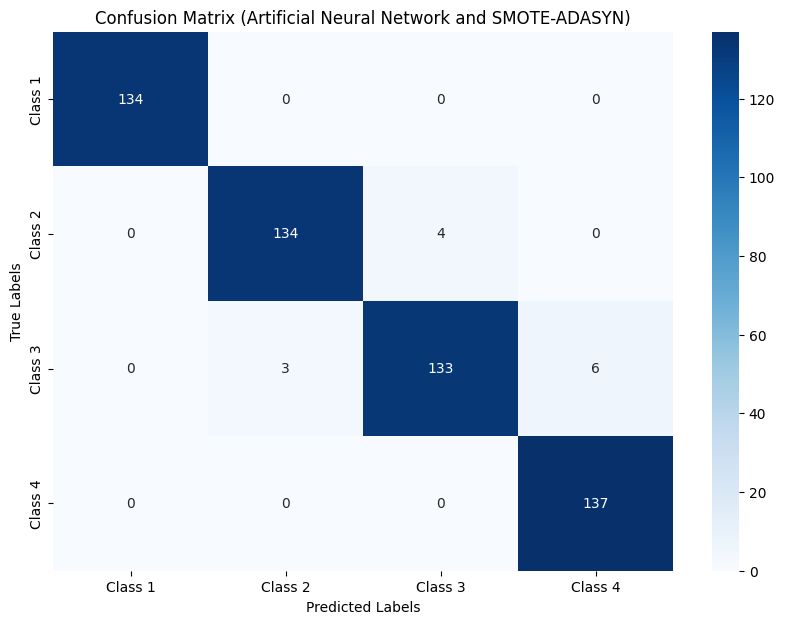

In [26]:
# Visualisasi Confusion Matrix untuk ANN
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_ann, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4'], yticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Artificial Neural Network and SMOTE-ADASYN)')
plt.show()


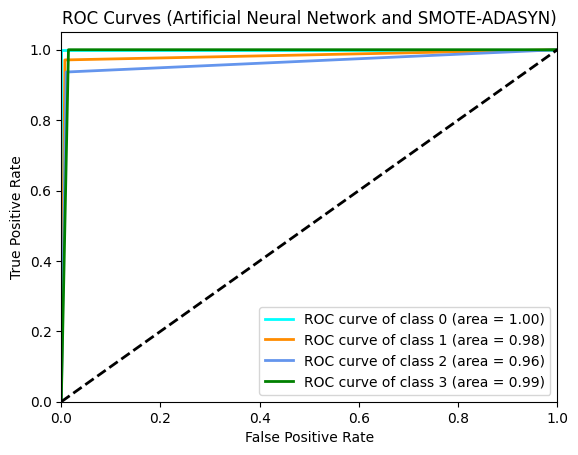

In [29]:
from sklearn.preprocessing import label_binarize

# Binarize the output for ROC curves
y_test_binarized = label_binarize(y_test_classes, classes=[0, 1, 2, 3])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_pred[:, i])

# Plot all ROC curves
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Artificial Neural Network and SMOTE-ADASYN)')
plt.legend(loc="lower right")
plt.show()

# Test New Data in a Machine Learning Model

In [30]:
# Test New Data
data_baru = pd.read_csv('/content/drive/MyDrive/Dataset/SynthesizedData.csv')

# Pastikan fitur sama dengan data latih
X_new = data_baru[['BOD', 'COD', 'FecalColiform', 'IP']]
y_new = data_baru['Class']

# Transformasi fitur baru
X_new = scaler.transform(X_new)

# Prediksi dengan model yang sudah dilatih
y_new_pred = model.predict(X_new)
y_new_pred_classes = y_new_pred.argmax(axis=1) + 1  # Adjust for 1-based index

# Pastikan label kelas konsisten
unique_classes = np.unique(np.concatenate((y, y_new)))
label_dict = {old_label: new_label for new_label, old_label in enumerate(unique_classes, 1)}  # Adjust for 1-based index

# Map old labels to new labels
y_new = np.vectorize(label_dict.get)(y_new)

# Tampilkan confusion matrix
print("Confusion Matrix Artificial Neural Network and SMOTE-ADASYN (New Data):")
conf_matrix_new = confusion_matrix(y_new, y_new_pred_classes)
print(conf_matrix_new)

# Tampilkan classification report
print("\nClassification Report Artificial Neural Network and SMOTE-ADASYN (New Data):")
print(classification_report(y_new, y_new_pred_classes))

# Tampilkan accuracy
print('Accuracy: ', accuracy_score(y_new, y_new_pred_classes))


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Confusion Matrix Artificial Neural Network and SMOTE-ADASYN (New Data):
[[499   1   0   0]
 [  1 370 129   0]
 [  0  47 445   8]
 [  0   0   3 497]]

Classification Report Artificial Neural Network and SMOTE-ADASYN (New Data):
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       500
           2       0.89      0.74      0.81       500
           3       0.77      0.89      0.83       500
           4       0.98      0.99      0.99       500

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.90      2000
weighted avg       0.91      0.91      0.90      2000

Accuracy:  0.9055


# Creating Visualization Plots on New Test Data for the Confusion Matrix and ROC Curves

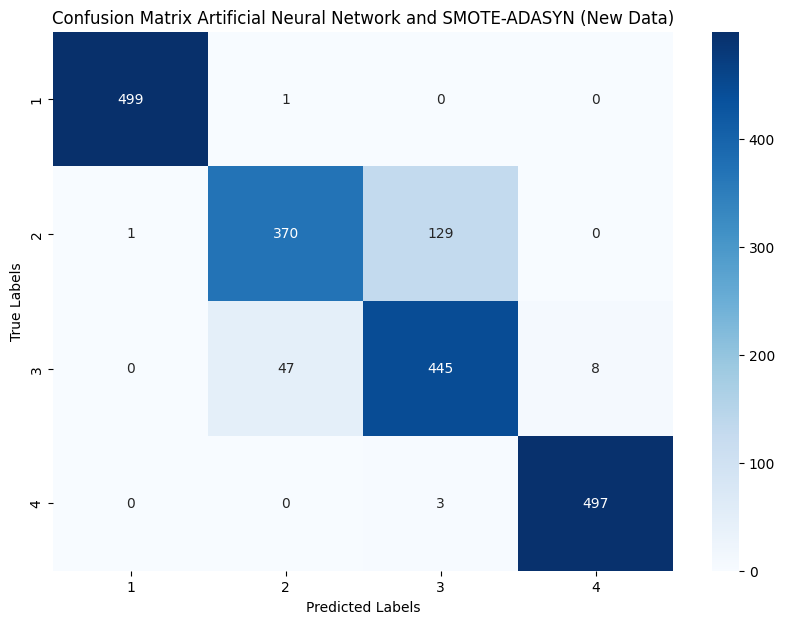

In [31]:
# Visualisasi Confusion Matrix untuk data baru
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_new, annot=True, fmt='d', cmap='Blues', xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Artificial Neural Network and SMOTE-ADASYN (New Data)')
plt.show()

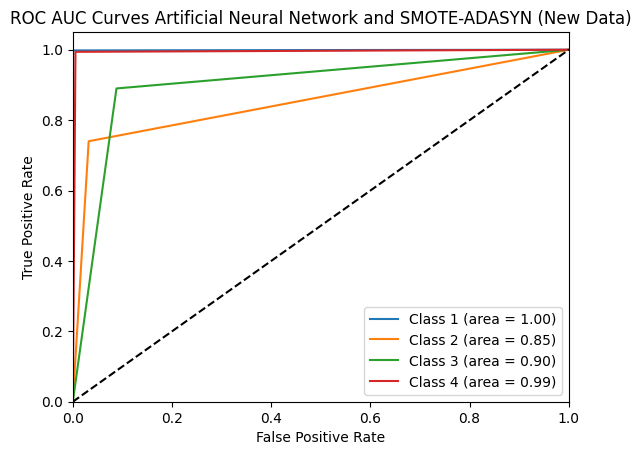

In [32]:
# Binarize the output
y_new_bin = label_binarize(y_new, classes=[1, 2, 3, 4])
n_classes = y_new_bin.shape[1]

# Get the ROC curve and AUC for each class
fpr_new = dict()
tpr_new = dict()
roc_auc_new = dict()

for i in range(n_classes):
    fpr_new[i], tpr_new[i], _ = roc_curve(y_new_bin[:, i], y_new_pred[:, i])
    roc_auc_new[i] = roc_auc_score(y_new_bin[:, i], y_new_pred[:, i])

# Plotting the ROC curve
plt.figure()
for i in range(n_classes):
    plt.plot(fpr_new[i], tpr_new[i], label=f'Class {unique_classes[i]} (area = {roc_auc_new[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curves Artificial Neural Network and SMOTE-ADASYN (New Data)')
plt.legend(loc="lower right")
plt.show()

# Evaluating the Model on New Test Data

In [33]:
# Hitung balanced accuracy
from sklearn.metrics import balanced_accuracy_score

balanced_acc = balanced_accuracy_score(y_new, y_new_pred_classes)
print("Balanced Accuracy (New Data):", balanced_acc)

Balanced Accuracy (New Data): 0.9055


In [34]:
# Hitung Matthews Correlation Coefficient (MCC)
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(y_new, y_new_pred_classes)
print("Matthews Correlation Coefficient (New Data):", mcc)

Matthews Correlation Coefficient (New Data): 0.8758526360020876


In [35]:
# Hitung Cohen's Kappa
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(y_new, y_new_pred_classes)
print("Cohen's Kappa (New Data):", kappa)

Cohen's Kappa (New Data): 0.874


# Simulation of a machine learning model for classifying the water quality of the Citarum River.

## Parameter Table for the Range of Pollution Index Values for the Classification of Citarum River Water Quality:
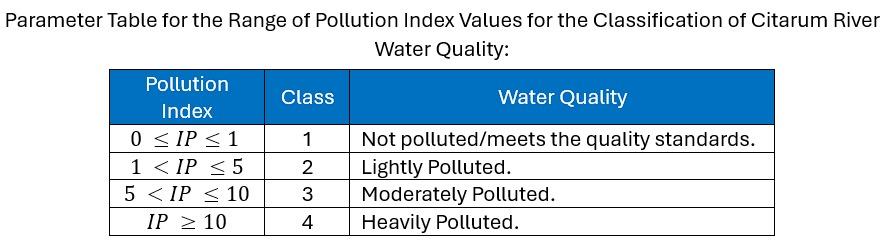



## Input one row of parameter data for model simulation

In [63]:
# Fungsi untuk klasifikasi menggunakan model ANN
def predict_quality_ann(BOD, COD, FecalColiform, IP):
    # Scaling input data
    input_data = scaler.transform([[BOD, COD, FecalColiform, IP]])

    # Predict using the trained ANN model
    prediction = model.predict(input_data).argmax(axis=1)[0]

    # Convert prediction to integer and adjust for 1-based index
    prediction = int(prediction) + 1

    # Class labels
    class_labels = {
        1: "Tidak tercemar/memenuhi baku mutu",
        2: "Tercemar ringan",
        3: "Tercemar sedang",
        4: "Tercemar berat"
    }

    return f"Kualitas Air Sungai Citarum: {class_labels.get(prediction, 'kelas tidak dikenal')} (Kelas {prediction})"

# Hasil Klasifikasi Kualitas Air Sungai Citarum
print(predict_quality_ann(2.5, 20, 100, 1))  # Ganti dengan nilai parameter yang sesuai

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Kualitas Air Sungai Citarum: Tidak tercemar/memenuhi baku mutu (Kelas 1)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


## Input each parameter data one by one for model simulation.

### First attempt

In [66]:
# Percobaan Pertama

# Fungsi untuk klasifikasi menggunakan model ANN
def predict_quality_ann(BOD, COD, FecalColiform, IP):
    # Scaling input data
    input_data = scaler.transform([[BOD, COD, FecalColiform, IP]])

    # Predict using the trained ANN model
    prediction = model.predict(input_data).argmax(axis=1)[0]

    # Convert prediction to integer and adjust for 1-based index
    prediction = int(prediction) + 1

    # Class labels
    class_labels = {
        1: "Tidak tercemar/memenuhi baku mutu",
        2: "Tercemar ringan",
        3: "Tercemar sedang",
        4: "Tercemar berat"
    }

    return f"Kualitas Air Sungai Citarum: {class_labels.get(prediction, 'kelas tidak dikenal')} (Kelas {prediction})"

# Fungsi untuk validasi input
def get_positive_float(prompt):
    while True:
        try:
            value = float(input(prompt))
            if value < 0:
                raise ValueError("Nilai tidak boleh negatif.🙏")
            return value
        except ValueError as e:
            print(f"Tolong masukkan nilai yang benar! {e}")

# Input parameter dari user
BOD = get_positive_float("Masukkan nilai BOD: ")
COD = get_positive_float("Masukkan nilai COD: ")
FecalColiform = get_positive_float("Masukkan nilai FecalColiform: ")
IP = get_positive_float("Masukkan nilai IP: ")

# Hasil Klasifikasi Kualitas Air Sungai Citarum
print(predict_quality_ann(BOD, COD, FecalColiform, IP))


Masukkan nilai BOD: 
Tolong masukkan nilai yang benar! could not convert string to float: ''
Masukkan nilai BOD: -1
Tolong masukkan nilai yang benar! Nilai tidak boleh negatif.🙏
Masukkan nilai BOD: 1.11
Masukkan nilai COD: 5
Masukkan nilai FecalColiform: 954
Masukkan nilai IP: 0.98
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Kualitas Air Sungai Citarum: Tidak tercemar/memenuhi baku mutu (Kelas 1)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


### Second attempt

In [67]:
# Percobaan Kedua

# Fungsi untuk klasifikasi menggunakan model ANN
def predict_quality_ann(BOD, COD, FecalColiform, IP):
    # Scaling input data
    input_data = scaler.transform([[BOD, COD, FecalColiform, IP]])

    # Predict using the trained ANN model
    prediction = model.predict(input_data).argmax(axis=1)[0]

    # Convert prediction to integer and adjust for 1-based index
    prediction = int(prediction) + 1

    # Class labels
    class_labels = {
        1: "Tidak tercemar/memenuhi baku mutu",
        2: "Tercemar ringan",
        3: "Tercemar sedang",
        4: "Tercemar berat"
    }

    return f"Kualitas Air Sungai Citarum: {class_labels.get(prediction, 'kelas tidak dikenal')} (Kelas {prediction})"

# Fungsi untuk validasi input
def get_positive_float(prompt):
    while True:
        try:
            value = float(input(prompt))
            if value < 0:
                raise ValueError("Nilai tidak boleh negatif.🙏")
            return value
        except ValueError as e:
            print(f"Tolong masukkan nilai yang benar! {e}")

# Input parameter dari user
BOD = get_positive_float("Masukkan nilai BOD: ")
COD = get_positive_float("Masukkan nilai COD: ")
FecalColiform = get_positive_float("Masukkan nilai FecalColiform: ")
IP = get_positive_float("Masukkan nilai IP: ")

# Hasil Klasifikasi Kualitas Air Sungai Citarum
print(predict_quality_ann(BOD, COD, FecalColiform, IP))

Masukkan nilai BOD: 5
Masukkan nilai COD: 16.2
Masukkan nilai FecalColiform: 90756
Masukkan nilai IP: 4.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Kualitas Air Sungai Citarum: Tercemar ringan (Kelas 2)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


### Third attempt

In [68]:
# Percobaan Ketiga

# Fungsi untuk klasifikasi menggunakan model ANN
def predict_quality_ann(BOD, COD, FecalColiform, IP):
    # Scaling input data
    input_data = scaler.transform([[BOD, COD, FecalColiform, IP]])

    # Predict using the trained ANN model
    prediction = model.predict(input_data).argmax(axis=1)[0]

    # Convert prediction to integer and adjust for 1-based index
    prediction = int(prediction) + 1

    # Class labels
    class_labels = {
        1: "Tidak tercemar/memenuhi baku mutu",
        2: "Tercemar ringan",
        3: "Tercemar sedang",
        4: "Tercemar berat"
    }

    return f"Kualitas Air Sungai Citarum: {class_labels.get(prediction, 'kelas tidak dikenal')} (Kelas {prediction})"

# Fungsi untuk validasi input
def get_positive_float(prompt):
    while True:
        try:
            value = float(input(prompt))
            if value < 0:
                raise ValueError("Nilai tidak boleh negatif.🙏")
            return value
        except ValueError as e:
            print(f"Tolong masukkan nilai yang benar! {e}")

# Input parameter dari user
BOD = get_positive_float("Masukkan nilai BOD: ")
COD = get_positive_float("Masukkan nilai COD: ")
FecalColiform = get_positive_float("Masukkan nilai FecalColiform: ")
IP = get_positive_float("Masukkan nilai IP: ")

# Hasil Klasifikasi Kualitas Air Sungai Citarum
print(predict_quality_ann(BOD, COD, FecalColiform, IP))

Masukkan nilai BOD: 11
Masukkan nilai COD: 25.4
Masukkan nilai FecalColiform: 40934
Masukkan nilai IP: 6.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Kualitas Air Sungai Citarum: Tercemar sedang (Kelas 3)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


### Fourth attempt

In [77]:
# Percobaan Keempat

# Fungsi untuk klasifikasi menggunakan model ANN
def predict_quality_ann(BOD, COD, FecalColiform, IP):
    # Scaling input data
    input_data = scaler.transform([[BOD, COD, FecalColiform, IP]])

    # Predict using the trained ANN model
    prediction = model.predict(input_data).argmax(axis=1)[0]

    # Convert prediction to integer and adjust for 1-based index
    prediction = int(prediction) + 1

    # Class labels
    class_labels = {
        1: "Tidak tercemar/memenuhi baku mutu",
        2: "Tercemar ringan",
        3: "Tercemar sedang",
        4: "Tercemar berat"
    }

    return f"Kualitas Air Sungai Citarum: {class_labels.get(prediction, 'kelas tidak dikenal')} (Kelas {prediction})"

# Fungsi untuk validasi input
def get_positive_float(prompt):
    while True:
        try:
            value = float(input(prompt))
            if value < 0:
                raise ValueError("Nilai tidak boleh negatif.🙏")
            return value
        except ValueError as e:
            print(f"Tolong masukkan nilai yang benar! {e}")

# Input parameter dari user
BOD = get_positive_float("Masukkan nilai BOD: ")
COD = get_positive_float("Masukkan nilai COD: ")
FecalColiform = get_positive_float("Masukkan nilai FecalColiform: ")
IP = get_positive_float("Masukkan nilai IP: ")

# Hasil Klasifikasi Kualitas Air Sungai Citarum
print(predict_quality_ann(BOD, COD, FecalColiform, IP))

Masukkan nilai BOD: 4.45
Masukkan nilai COD: 26.78
Masukkan nilai FecalColiform: 155678
Masukkan nilai IP: 15.25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Kualitas Air Sungai Citarum: Tercemar berat (Kelas 4)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


# Save Model Machine Learning

In [79]:
# Simpan model dan scaler ke file pickle
joblib.dump(model, 'model_ann.pkl')
joblib.dump(scaler, 'scaler_ann.pkl')

NameError: name 'joblib' is not defined

In [78]:
import sklearn
print(sklearn.__version__)


1.2.2
